## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [70]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef

me.mechanics_printing()

### Define the Model

#### Create Parameter instance

In [95]:
b_modes = 2
t_modes = 2
fwt_modes = 1
# lets go for B2T2 (so 5 DoF)
p = mf.ModelParameters.DynamicModel(b_modes + t_modes + fwt_modes)

## Create some global parameters
p.c = mf.ModelSymbol(value = 1.8,string = 'c') # chord of wing
p.s_t = mf.ModelSymbol(value = 12,string = 's_t') # total semi-span of wing
p.rho_t = mf.ModelSymbol(value = 19.53,string = 'rho_t') # per per unit area (kg/m^2)
p.ratio_fwt = mf.ModelSymbol(value = 0.2,string = 'sigma') # percentage of wing that is a FWT


# Respective spans
p.s_0 =  p.s_t*(1-p.ratio_fwt) # span of inner wing
p.s_1 =  p.s_t*p.ratio_fwt # span of inner wing

# Inner Wing stiffness Properties
p.EI = mf.ModelSymbol(value = 9.77e6,string = 'EI') # Bending stiffness for the wing
p.GJ = mf.ModelSymbol(value = 0.99e6,string = 'GJ') # Torsional Stiffness for the wing

# Location of flexural axes
p.e_0 = mf.ModelSymbol(value = 0.08,string = 'e_0')
p.x_f0 = sym.Rational(1,4)*p.c + p.e_0*p.c
p.e_1 = mf.ModelSymbol(value = 0,string = 'e_1') # e for the FWT
p.x_f1 = sym.Rational(1,4)*p.c + p.e_1*p.c

# FWT Properties
p.m_1 =  mf.ModelSymbol(value = p.rho_t.value*p.c.value*p.s_t.value*p.ratio_fwt.value,string = 'm_1') # FWT mass
p.I_xx_1 = sym.Rational(1,12)*p.m_1*p.s_1**2 # inertia of FWT (uniform bar)
p.Lambda = mf.ModelSymbol(value = np.deg2rad(10),string = 'Lambda') # Flare Angle
p.Delta_m = mf.ModelSymbol(value = 0,string = 'Delta_m') # additional mass to apply at the FWT CoM

# Symbols to translate along inner wing and FWT
p.y_0 = sym.Symbol('y_0') # inner wing y chord
p.x_0 = sym.Symbol('x_0') # inner wing x chord
p.y_1 = sym.Symbol('y_1') # FWT y chord
p.x_1 = sym.Symbol('x_1') # FWT x chord

## Aero Parameters
p.rho = mf.ModelSymbol(value = 1.225,string = 'rho')                 # density
p.V = mf.ModelSymbol(value = 10,string = 'V')                        # velocity
p.g  = mf.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.alpha_r = mf.ModelSymbol(value = np.deg2rad(3),string = 'alpha_r') # root AoA
p.M_thetadot = mf.ModelSymbol(value = -1.2,string = 'M_thetadot')    # Unsteady Torsional Term 

## Main Wing Specific
p.a_0 = mf.ModelSymbol(value = 2*np.pi,string = 'a_0')               # C_L slope of main wing

## FWT Specific
p.a_1 = p.a_0 - p.a_0/p.s_1*p.y_1                                    # C_L slope of FWT
p.alpha_1 = mf.ModelSymbol(value = 0,string = 'alpha_1')             # FWT alpha
p.alphadot_1 = mf.ModelSymbol(value = 0,string = 'alphadot_1')       # FWT alphadot

## Numeric Model Constants
p.fp = mf.ModelMatrix(value =[0]*p.qs*2,symbols=sym.symbols(f'qtilde:{p.qs*2}')) # The stationary point

# Factor to change the size of joint values
p.eta = mf.ModelMatrix(value = [1]*(b_modes+t_modes+fwt_modes),symbols=sym.symbols(f'eta:{p.qs}'))

In [96]:
#get shape functions for main wing
z_0,tau_0 = mf.ShapeFunctions_BN_TM(b_modes,t_modes,p.q[:-1],p.y_0,p.x_0,p.x_f0,0,factor=p.eta)

#define wrefernce frames
wing_root_frame = mf.HomogenousTransform().R_y(p.alpha_r)
wing_frame = wing_root_frame.Translate(p.x_0,p.y_0,z_0)
wing_flexural_frame = wing_frame.subs({p.x_0:p.x_f0})

fwt_root_frame = wing_frame.subs({p.y_0:p.s_0,p.x_0:p.x_f0}).Translate(-p.x_f0,0,0).R_x(-p.q[-1])
fwt_flexural_frame = fwt_root_frame.Translate(p.x_f1,p.y_1,0)
fwt_com_frame = fwt_root_frame.Translate(p.c/2,p.s_1/2,0)

tau_s0 = tau_0 if isinstance(tau_0,int) else tau_0.subs(p.y_0,p.s_0)
alpha_fwt = tau_s0 + p.alpha_1
alphadot_fwt = tau_s0 if isinstance(tau_0,int) else tau_s0.diff(me.dynamicsymbols._t) + p.alphadot_1

#### Create Transforms

In [4]:


#Create Elemnts
M_wing = ele.MassMatrix(p.rho_t)
M_fwt = ele.MassMatrix(p.m_1,I_xx = p.I_xx_1)

inner_wing_ele = ele.FlexiElement(wing_root_frame,M_wing,p.x_0,p.y_0,z_0,p.c,p.s_0,p.x_f0,p.EI,p.GJ,gravityPot=True)
fwt_ele = ele.RigidElement(fwt_com_frame,M_fwt,True)

# Create AeroForces
wing_AeroForces = ef.AeroForce.Generate(p,wing_flexural_frame,p.a_0,(p.y_0,0,p.s_0),
                               alphadot = tau_0 if isinstance(tau_0,int) else tau_0.diff(me.dynamicsymbols._t),
                               M_thetadot = p.M_thetadot,
                               e = p.e_0,
                               rootAlpha = p.alpha_r,
                               deltaAlpha = tau_0,
                               alpha_zero = 0)




fwt_AeroForces = ef.AeroForce.Generate(p,fwt_flexural_frame,p.a_1,(p.y_1,0,p.s_1),
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               rootAlpha = alpha_fwt,
                               deltaAlpha = 0,
                               alpha_zero = 0)

# Setup AoA of FWT
fwt_aoa = mf.GetAoA(p.alpha_r,0,p.Lambda,p.q[-1])

## Sub in Aero Forces
fwt_AeroForces = fwt_AeroForces.subs(p,{p.alpha_1:fwt_aoa,p.alphadot_1:fwt_aoa.diff(time)})

In [5]:
#Create Composite force
CompositeForce = ef.CompositeForce(p,[wing_AeroForces,fwt_AeroForces])
# Create the SYmbolic Model
sm = mf.SymbolicModel.FromElementsAndForces(p,[inner_wing_ele,fwt_ele],CompositeForce)

# Setup Numeric Model Parameters


In [6]:
tmax, dt = 5, 0.01
    
ts = np.arange(0, tmax+dt, dt)

constraints = [np.NaN]*p.qs*2
const_idx = np.isnan(constraints)

def objectiveDeriv(t,y):
    deriv = sm.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

## create masses 

In [7]:
y0 = [0]*p.qs*2
sm_mini = sm.subs(p,{p.alpha_1:p.alpha_1.value,p.alphadot_1:p.alphadot_1.value})
#sm_mini = sm_mini.subs(p,p.GetSubs(0,[0]*p.qs*2,ignore=[p.eta,p.EI,p.GJ,p.s_t,p.f_0,p.e_0,p.M_thetadot,p.V,p.alpha_1,p.alphadot_1,p.alpha_r]))

def objectiveDeriv(t,y):
    deriv = sm_mini.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

In [8]:
def objectiveDeriv(t,y):
    deriv = sm_mini.deriv(t,y,p.GetNumericTuple(y,t))
    return tuple(np.where(const_idx,deriv,constraints))

#set velocity and alpha_r funcs
def Vfunc(t,x):
    return 20

p.V.value = Vfunc

y0 = p.fp.value
y0 = [0]*p.qs*2
yData = solve_ivp(objectiveDeriv,(0,15),y0)
#yData = solve_ivp(objectiveDeriv,(0,tmax),yi[:,-1])

func_alpha = alpha_fwt.subs(p.GetSubs(0,y0))

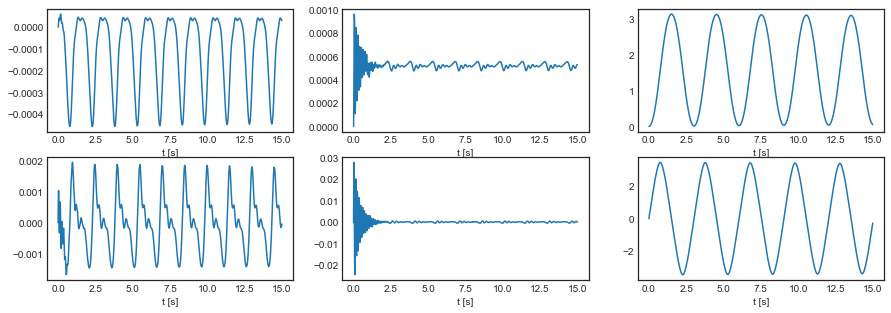

In [9]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    #axes[0][i].set(xlim=(0,0.1))
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')
    #axes[1][i].set(xlim=(0,0.1))

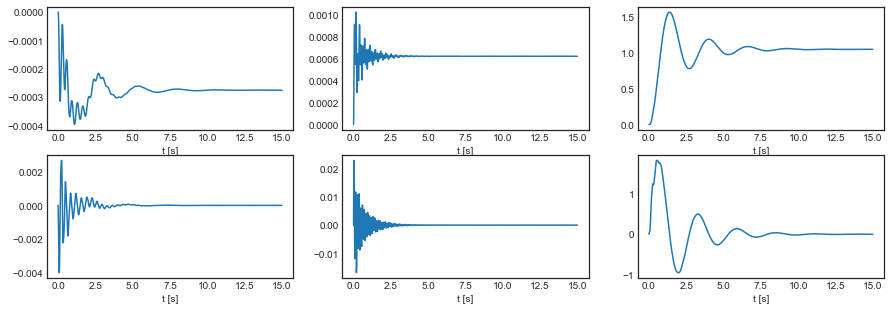

In [67]:
yi = yData.y
t = yData.t

plt.style.use('seaborn-white')

fig, axes = plt.subplots(2,int(len(yi)/2),figsize=(15,5))

for i in range(int(len(yi)/2)):
    # pos plot
    axes[0][i].plot(t,yi[i*2])
    axes[0][i].set_ylabel('')
    axes[0][i].set_xlabel('t [s]')
    #axes[0][i].set(xlim=(0,0.1))
    
    # vel plot
    axes[1][i].plot(t,yi[i*2+1])
    axes[1][i].set_ylabel('')
    axes[1][i].set_xlabel('t [s]')
    #axes[1][i].set(xlim=(0,0.1))

## Create the linearised EoM about some Stationary point

In [115]:
ignores = [p.EI,p.V,p.GJ,p.s_t,p.e_0,p.rho_t,p.m_1,p.alpha_r,p.ratio_fwt,p.Lambda]

# get the linearised sm
sm_lin = sm.subs(p,p.GetSubs(0,p.fp,ignore=ignores)).linearise(p)

# get eigen Matrices and turn into a function
K,M = sm_lin.eigenMatrices(p)
func = sym.lambdify((ignores + [p.fp]),(K,M))

In [140]:
f = (sm_mini.f-sm_mini.ExtForces.Q()).subs({i:0 for i in p.qd}).subs(p.GetSubs(0,[0]*p.qs*2,ignore=ignores))
func_obj = sym.lambdify((p.q,ignores),f)
func_jac_obj = sym.lambdify((p.q,ignores),f.jacobian(p.q))

In [203]:
# set fixed variables
p.ratio_fwt.value = 0.1

#create dict of variations
vars_ls =[]
vars_ls.append((p.m_1,np.array([0.5,1,1.5,2])*(p.rho_t.value*p.c.value*p.s_t.value*p.ratio_fwt.value)))
vars_ls.append((p.Lambda,np.deg2rad([10,17.5,25])))
vars_ls.append((p.alpha_r,np.deg2rad([0,5,10])))
vars_ls.append((p.V,np.linspace(0,150,151))) # ensure velocity last so that fixed points iterats up the velocity
#generate fixed points

#create an array of all possible permutations
perms = np.array(np.meshgrid(*[v for k,v in vars_ls ])).T.reshape(-1,len(vars_ls))

#put in pandas array
df = pd.DataFrame(data = perms, columns=[k.name for k,v in vars_ls])
df['q']=list
df = df.sort_values(by=[k.name for k,v in vars_ls]).reset_index()

In [204]:
## Find fixed point for each use case
pLast = [0]*p.qs
pLast[-1] = np.pi/2
for i in range(len(df)):
    
    #set param values
    for k,v in vars_ls:
        k.value = df[k.name].iloc[i]
    
    #set the initial guess (if v=0 set to FWT dropped doen else use previous result)
    if p.V.value == 0:
        q_guess = [0]*p.qs
        q_guess[-1] = np.pi/2
    else:
        q_guess = df.at[i-1,'q'][::2]
    values = tuple([i.value for i in ignores])
    qf = fsolve(lambda q,v: func_obj(q,values)[:,0],q_guess,fprime = func_jac_obj ,factor = 1,args=(values,))
    #print(f'{np.round(q_guess[-1],2)},{np.round(qf[-1],2)},{p.V.value}')
    #save result
    yf = [0]*p.qs*2  
    yf[::2] = qf
    df.at[i,'q'] = yf

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The number of calls to function has reached maxfev = 800.
  warnings.warn(msg, RuntimeWarning)


In [205]:
df['a'] = df.apply(lambda r:r.q[-2],axis=1)
df[['V','a','alpha_r']].head(10)

,V,a,alpha_r
0,0.0,1.570796,0.0
1,1.0,1.568341,0.0
2,2.0,1.560976,0.0
3,3.0,1.548712,0.0
4,4.0,1.531566,0.0
5,5.0,1.509580,0.0
6,6.0,1.482820,0.0
7,7.0,1.451397,0.0
8,8.0,1.415480,0.0
9,9.0,1.375304,0.0


In [206]:
#Calc freqs and dampings
flutdfv2 = pd.DataFrame() 
for i in range(0,len(df)):
    
    #set param values
    for k,v in vars_ls:
        k.value = df[k.name].iloc[i]

    q = df.at[i,'q']
    
    values = tuple([i.value for i in ignores])
    evals, evecs = eig(*func(*values,q))
    jac_dat = mf.ExtractEigenValueData(evals,evecs,sortby='Frequency')

    # populate test specific data
    for k,v in vars_ls:
        jac_dat[k.name] = k.value
        
    # populate fixed point data
    y = np.array(q)
    for i in range(len(y)):
        jac_dat[f'q_{i}'] =y[i]
    flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True) 

In [207]:
flutdfv2['m_1'].unique()

array([21.0924, 42.1848, 63.2772, 84.3696])

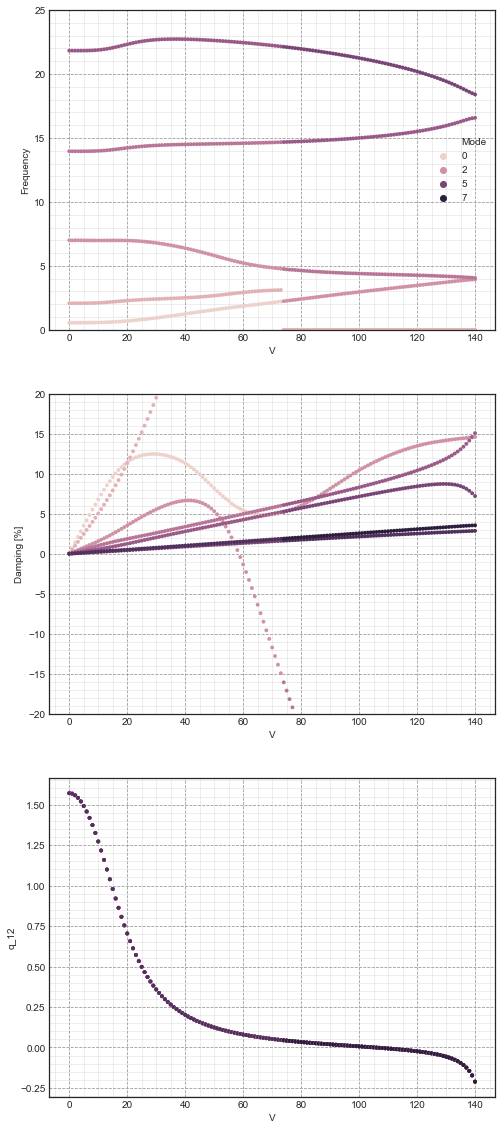

In [208]:
data = flutdfv2.copy()
data = data[data['Lambda']==np.deg2rad(25)]
data = data[data['alpha_r']==np.deg2rad(0)]
data = data[data['m_1']>40]
data = data[data['m_1']<50]
data = data[data['V']<=140]
data['Damping [%]'] = data['Damping']*-100
#print(data[['V','q_12']].head(50))
#data = flutdfv2
fig, axes = plt.subplots(3,1,figsize=(8,20))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mode',ax=axes[0],edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Damping [%]',hue='Mode',ax=axes[1],legend=False,edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y=f'q_{p.qs*2-2}',hue='Mode',ax=axes[2],legend=False,edgecolor = 'none',s=15)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,25))
axes[1].set(ylim=(-20,20))

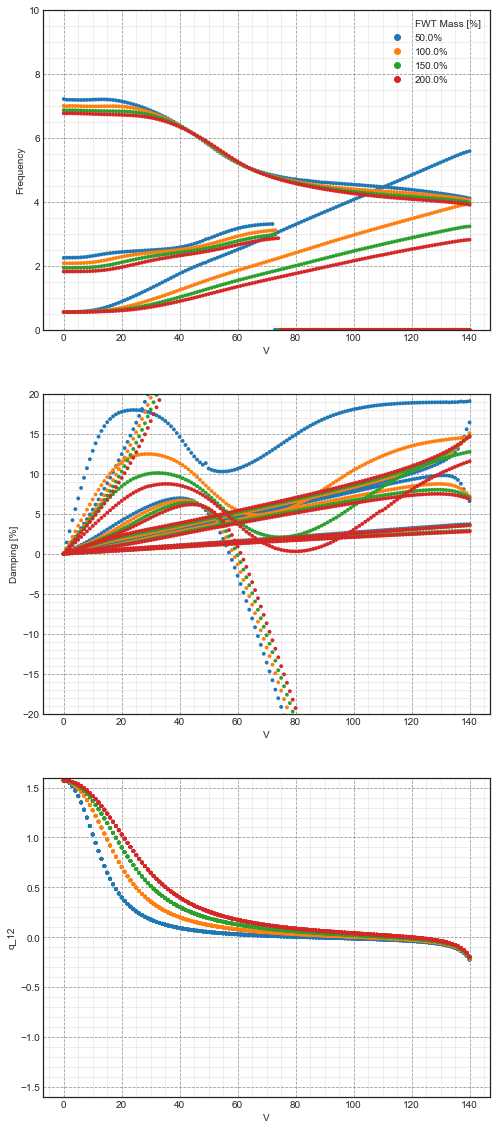

In [209]:
data = flutdfv2.copy()
data = data[data['V']<=140]
data['Damping [%]'] = data['Damping']*-100
data['$\Lambda$ [deg]'] = [str(i)+' deg' for i in np.rad2deg(data['Lambda'])]
data['AoA [deg]'] = [str(i)+' deg' for i in np.rad2deg(data['alpha_r'])]
data['FWT Mass [%]'] = [str(i)+'%' for i in data['m_1']/data['m_1'].max()*200]
#print(data[['V','q_12']].head(50))
#data = flutdfv2
fig, axes = plt.subplots(3,1,figsize=(8,20))

#huestr = 'AoA [deg]'
#huestr = '$\Lambda$ [deg]'
huestr = 'FWT Mass [%]'

data = data[data['Lambda']==np.deg2rad(25)]
data = data[data['alpha_r']==np.deg2rad(00)]
#data = data[data['m_1']>40]
#data = data[data['m_1']<50]


sns.scatterplot(data=data,x='V',y='Frequency',hue=huestr,ax=axes[0],edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y='Damping [%]',hue=huestr,ax=axes[1],legend=False,edgecolor = 'none',s=15)
sns.scatterplot(data=data,x='V',y=f'q_{p.qs*2-2}',hue=huestr,ax=axes[2],legend=False,edgecolor = 'none',s=15)

for i in [0,1,2]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    #axes[i].set(xlim=(0,60))
#axes[0].set(ylim=(0.5,3))
axes[0].set(ylim=(0,10))
axes[1].set(ylim=(-20,20))
axes[2].set(ylim=(-1.6,1.6))

In [114]:
import sympy as sym
from ModelFramework.ExternalForces import ExternalForce
from ModelFramework import msub,LineariseMatrix

class AeroForce(ExternalForce):

    @classmethod
    def Generate(cls,FwtParams,Transform,C_L,int_tuple,alphadot,M_thetadot,e,rootAlpha,deltaAlpha,alpha_zero = 0):
        p = FwtParams
        ## force per unit length will following theredosons pseado-steady theory
        
        BJ = cls._trigsimp(Transform.InvAdjoint()*Transform.ManipJacobian(p.q))
        
        #print()

        # add z velocity due to motion
        v_z_eff = (BJ*p.qd)[2] # cls._trigsimp(sym.simplify(Transform.BodyVelocity()[2]))

        # combine to get effective AoA
        dAlpha = alpha_zero + rootAlpha + deltaAlpha - v_z_eff/p.V

        # Calculate the lift force
        dynamicPressure = sym.Rational(1,2)*p.rho*p.V**2
        dL_w = dynamicPressure*p.c*C_L*dAlpha

        # Calulate the pitching Moment
        dM_w = dL_w*e*p.c # Moment due to lift
        dM_w += dynamicPressure*p.c**2*(M_thetadot*alphadot*p.c/(sym.Integer(4)*p.V))

        ## joint torques for lift are calculated in a frame aligned with the chordwise velocity direction
        wrench_lift = sym.Matrix([0,0,dL_w,0,0,0])
        #velocity_frame = Transform

        #dQ_L = (velocity_frame.ManipJacobian(p.q)).T
        #dQ_L *= velocity_frame.InvAdjoint().T
        #dQ_L =cls._trigsimp(dQ_L)
        dQ_L = BJ.T*wrench_lift

        ## joint torques for lift are calculated in a frame aligned with the chordwise velocity direction
        wrench_moment = sym.Matrix([0,0,0,0,dM_w,0])
        velocity_frame = Transform.R_y(deltaAlpha)
        
        BJ_M = velocity_frame.InvAdjoint()
        BJ_M *= (velocity_frame.ManipJacobian(p.q))     
        BJ_M = cls._trigsimp(BJ_M)
        
        dQ_M = BJ_M.T*wrench_moment
        
        
        #Aprime = BJ_M.T
        #A = Aprime.integrate(int_tuple)
        #B = wrench_moment
        #Bprime = B.diff(int_tuple[0])
        #AB = A*B 
        #_Q_M = AB.subs(int_tuple[0],int_tuple[2]) - AB.subs(int_tuple[0],int_tuple[1]) - (A*Bprime).integrate(int_tuple)
        

        #_Q = dQ_L.integrate(int_tuple) + dQ_M.integrate(int_tuple)
        _Q = dQ_L + dQ_M

        # generalised force
        #_Q = dQ.integrate(int_tuple)
        return cls(p,_Q,dAlpha)
        
    def __init__(self,p,Q,dAlpha):
        tup = p.GetTuple()
        self.dAlpha = dAlpha
        super().__init__(p,Q) 

    @staticmethod
    def _trigsimp(expr):
        return sym.trigsimp(sym.powsimp(sym.cancel(sym.expand(expr))))      

    def linearise(self,p):
        Q_lin = LineariseMatrix(self.Q(),p.x,p.fp)
        dAlpha_lin = LineariseMatrix(self.dAlpha,p.x,p.fp)
        return AeroForce(p,Q_lin,dAlpha_lin)
    
    def subs(self,p,*args):
        return AeroForce(p,self._Q.subs(*args),self.dAlpha.subs(*args))



In [120]:
%%time
test = AeroForce.Generate(p,fwt_flexural_frame,p.a_1,(p.y_1,0,p.s_1),
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               rootAlpha = alpha_fwt,
                               deltaAlpha = 0,
                               alpha_zero = 0)
test.Q().jacobian(p.qd).simplify()

CPU times: user 11.8 s, sys: 51.6 ms, total: 11.9 s
Wall time: 11.9 s


⎡               5   ⎛ 4      3      2          ⎞    2                         
⎢   -V⋅a₀⋅c⋅ρ⋅sₜ ⋅σ⋅⎝σ  - 4⋅σ  + 6⋅σ  - 4⋅σ + 1⎠⋅cos (q₄)            V⋅a₀⋅c⋅ρ⋅
⎢   ──────────────────────────────────────────────────────           ─────────
⎢                               2                                             
⎢                           4⋅η₀                                              
⎢                                                                             
⎢           6   ⎛ 5      4       3       2          ⎞    2                  7 
⎢V⋅a₀⋅c⋅ρ⋅sₜ ⋅σ⋅⎝σ  - 5⋅σ  + 10⋅σ  - 10⋅σ  + 5⋅σ - 1⎠⋅cos (q₄)  -V⋅a₀⋅c⋅ρ⋅sₜ ⋅
⎢─────────────────────────────────────────────────────────────  ──────────────
⎢                           4⋅η₀⋅η₁                                           
⎢                                                                             
⎢                                                                             
⎢                              0                    

In [121]:
y0 = [0]*p.qs*2

tup = p.GetNumericTuple(y0,t)
%timeit -n 10 -r 1 test(tup,y0,0)


63.2 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [122]:
import sympy as sym
from ModelFramework.ExternalForces import ExternalForce
from ModelFramework import msub,LineariseMatrix

class AeroForce(ExternalForce):

    @classmethod
    def Generate(cls,FwtParams,Transform,C_L,int_tuple,alphadot,M_thetadot,e,rootAlpha,deltaAlpha,alpha_zero = 0):
        p = FwtParams
        ## force per unit length will following theredosons pseado-steady theory

        # add z velocity due to motion
        v_z_eff = cls._trigsimp(sym.simplify(Transform.BodyVelocity()[2]))

        # combine to get effective AoA
        dAlpha = alpha_zero + rootAlpha + deltaAlpha - v_z_eff/p.V

        # Calculate the lift force
        dynamicPressure = sym.Rational(1,2)*p.rho*p.V**2
        dL_w = dynamicPressure*p.c*C_L*dAlpha

        # Calulate the pitching Moment
        dM_w = dL_w*e*p.c # Moment due to lift
        dM_w += dynamicPressure*p.c**2*(M_thetadot*alphadot*p.c/(sym.Integer(4)*p.V))

        ## joint torques for lift are calculated in a frame aligned with the chordwise velocity direction
        wrench_lift = sym.Matrix([0,0,dL_w,0,0,0])
        velocity_frame = Transform

        dQ_L = (velocity_frame.ManipJacobian(p.q)).T
        dQ_L *= velocity_frame.InvAdjoint().T
        dQ_L =cls._trigsimp(dQ_L)
        dQ_L *= wrench_lift

        ## joint torques for lift are calculated in a frame aligned with the chordwise velocity direction
        wrench_moment = sym.Matrix([0,0,0,0,dM_w,0])
        velocity_frame = Transform.R_y(deltaAlpha)

        dQ_M = (velocity_frame.ManipJacobian(p.q)).T
        dQ_M *= velocity_frame.InvAdjoint().T
        dQ_M = cls._trigsimp(dQ_M)
        dQ_M *= wrench_moment

        dQ = dQ_L + dQ_M

        # generalised force
        _Q = dQ.integrate(int_tuple)
        return cls(p,_Q,dAlpha)
        
    def __init__(self,p,Q,dAlpha):
        tup = p.GetTuple()
        self.dAlpha = dAlpha
        super().__init__(p,Q) 

    @staticmethod
    def _trigsimp(expr):
        return sym.trigsimp(sym.powsimp(sym.cancel(sym.expand(expr))))      

    def linearise(self,p):
        Q_lin = LineariseMatrix(self.Q(),p.x,p.fp)
        dAlpha_lin = LineariseMatrix(self.dAlpha,p.x,p.fp)
        return AeroForce(p,Q_lin,dAlpha_lin)
    
    def subs(self,p,*args):
        return AeroForce(p,self._Q.subs(*args),self.dAlpha.subs(*args))



In [123]:
%%time
test = AeroForce.Generate(p,fwt_flexural_frame,p.a_1,(p.y_1,0,p.s_1),
                               alphadot = alphadot_fwt,
                               M_thetadot = p.M_thetadot,
                               e = p.e_1,
                               rootAlpha = alpha_fwt,
                               deltaAlpha = 0,
                               alpha_zero = 0)
test.Q().jacobian(p.qd).simplify()

CPU times: user 11.8 s, sys: 24.9 ms, total: 11.8 s
Wall time: 11.8 s


⎡               5   ⎛ 4      3      2          ⎞    2                         
⎢   -V⋅a₀⋅c⋅ρ⋅sₜ ⋅σ⋅⎝σ  - 4⋅σ  + 6⋅σ  - 4⋅σ + 1⎠⋅cos (q₄)            V⋅a₀⋅c⋅ρ⋅
⎢   ──────────────────────────────────────────────────────           ─────────
⎢                               2                                             
⎢                           4⋅η₀                                              
⎢                                                                             
⎢           6   ⎛ 5      4       3       2          ⎞    2                  7 
⎢V⋅a₀⋅c⋅ρ⋅sₜ ⋅σ⋅⎝σ  - 5⋅σ  + 10⋅σ  - 10⋅σ  + 5⋅σ - 1⎠⋅cos (q₄)  -V⋅a₀⋅c⋅ρ⋅sₜ ⋅
⎢─────────────────────────────────────────────────────────────  ──────────────
⎢                           4⋅η₀⋅η₁                                           
⎢                                                                             
⎢                                                                             
⎢                              0                    

In [124]:
y0 = [0]*p.qs*2

tup = p.GetNumericTuple(y0,t)
%timeit -n 10 -r 1 test(tup,y0,0)

57.9 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10 loops each)


In [31]:
%%timeit -n 4 -r 1
Q = (fwt_force[0]*fwt_force[1]+fwt_force[2]*fwt_force[3]).integrate((p.y_1,0,p.s_1))

2.17 s ± 0 ns per loop (mean ± std. dev. of 1 run, 4 loops each)


In [35]:
%%timeit -n 4 -r 1

int_tuple = (p.y_1,0,p.s_1)

#Q_L = (fwt_force[0]*fwt_force[1]).integrate(int_tuple)
A = fwt_force[0]
Aprime = u.diff(p.y_1)
B = fwt_force[1].integrate(int_tuple)
Q_L = A*B - (Aprime*B).integrate(int_tuple)

A = fwt_force[2].integrate(int_tuple)
B = fwt_force[3]
Bprime = B.diff(p.y_1)
Q_M = A*B - (A*Bprime).integrate(int_tuple)

Q = Q_L + Q_M

521 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 4 loops each)


In [37]:
fwt_force[1]

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                    ⎛       2        2                          3  3         
⎢ 2     ⎛     a₀⋅y₁⎞ ⎜     sₜ ⋅(1 - σ) ⋅q₃   sₜ⋅(1 - σ)⋅q₂   - sₜ ⋅σ ⋅η₀⋅cos(q
⎢V ⋅c⋅ρ⋅⎜a₀ - ─────⎟⋅⎜α₁ + ─────────────── + ───────────── - ─────────────────
⎢       ⎝      sₜ⋅σ⎠ ⎝            η₃               η₂                         
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [43]:
    BodyJac = (fwt_flexural_frame.ManipJacobian(p.q)).T
    BodyJac *= fwt_flexural_frame.InvAdjoint().T
    BodyJac = _trigsimp(BodyJac)
    BodyJac

⎡      2        2              2        2                   ⎤
⎢   -sₜ ⋅(σ - 1) ⋅sin(q₄)    sₜ ⋅(σ - 1) ⋅cos(q₄)           ⎥
⎢0  ──────────────────────   ────────────────────   0   0  0⎥
⎢             η₀                      η₀                    ⎥
⎢                                                           ⎥
⎢      3        3              3        3                   ⎥
⎢    sₜ ⋅(σ - 1) ⋅sin(q₄)   -sₜ ⋅(σ - 1) ⋅cos(q₄)           ⎥
⎢0   ────────────────────   ──────────────────────  0   0  0⎥
⎢             η₁                      η₁                    ⎥
⎢                                                           ⎥
⎢0            0                       0             0   0  0⎥
⎢                                                           ⎥
⎢0            0                       0             0   0  0⎥
⎢                                                           ⎥
⎣0            0                      -y₁            -1  0  0⎦

In [45]:
_trigsimp(fwt_flexural_frame.ManipJacobian(p.q))

⎡  2        2             3        3                                          
⎢sₜ ⋅(σ - 1) ⋅sin(αᵣ)  -sₜ ⋅(σ - 1) ⋅sin(αᵣ)                                  
⎢────────────────────  ──────────────────────  0  0               sₜ⋅(1 - σ)⋅s
⎢         η₀                     η₁                                           
⎢                                                                             
⎢                                                      2        2             
⎢                                                    sₜ ⋅(σ - 1) ⋅(sₜ⋅σ⋅η₀⋅q₁ 
⎢         0                      0             0  0  ─────────────────────────
⎢                                                                       η₀⋅η₁ 
⎢                                                                             
⎢  2        2             3        3                                          
⎢sₜ ⋅(σ - 1) ⋅cos(αᵣ)  -sₜ ⋅(σ - 1) ⋅cos(αᵣ)                                  
⎢────────────────────  ──────────────────────  0  0 

In [50]:
fwt_flexural_frame.ManipJacobian(p.q).shape